## Cargar Datos

In [ ]:
# Cargar Datos CSV
import pandas as pd
data = pd.read_csv('DatosSingapore2.csv')

## Organizar variables y conjuntos de train y test para el modelo con todos los datos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Detectar columnas binarias
binary_vars = [col for col in data.columns 
               if set(data[col].dropna().unique()).issubset({0, 1})]

# 2. Detectar columnas numéricas verdaderas
numerical_vars = data.select_dtypes(include=['number']).columns
numerical_true = [col for col in numerical_vars if col not in binary_vars]

# 3. Features
X = data[binary_vars + numerical_true]

# 4. Escalar únicamente numéricas continuas
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_true] = scaler.fit_transform(X[numerical_true])

# Eliminar price de x_scaled si está presente
if 'price' in X_scaled.columns:
    X_scaled = X_scaled.drop(columns=['price'])

# 5. Convertir todos los datos a float32
y = data["price"].astype("float32")
X_scaled = X_scaled.astype("float32")

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Crear función del modelo

In [ ]:
import tensorflow as tf
from tensorflow import keras

def create_model(n_neurons=64, n_layers=2, lr=0.001, dropout_rate=0.0,
                 hidden_activation="relu", output_activation="linear"):
    
    model = keras.Sequential()
    
    # Capa de entrada
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    # Capas ocultas
    for _ in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, activation=hidden_activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))

    # Capa de salida
    model.add(keras.layers.Dense(1, activation=output_activation))

    # Compilar
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )
    
    return model

## Guardar modelos en MLflow

In [ ]:
import mlflow
import mlflow.tensorflow
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mlflow.set_experiment("Airbnb_price_regression_3")

def train_and_log(params):
    n_neurons = params["n_neurons"]
    n_layers = params["n_layers"]
    lr = params["lr"]
    dropout = params["dropout"]
    hidden_activation = params["hidden_activation"]
    output_activation = params["output_activation"]

    with mlflow.start_run():

        # Registrar parámetros del modelo
        mlflow.log_params(params)

        # Crear modelo
        model = create_model(
            n_neurons=n_neurons,
            n_layers=n_layers,
            lr=lr,
            dropout_rate=dropout,
            hidden_activation=hidden_activation,
            output_activation=output_activation
        )

        # Entrenamiento
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            verbose=0
        )

        # Predicción
        preds = model.predict(X_test).flatten()

        # Métricas
        mse = mean_squared_error(y_test, preds)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)

        # Registrar métricas
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        # Registrar activaciones usadas
        mlflow.log_param("hidden_activation", hidden_activation)
        mlflow.log_param("output_activation", output_activation)

        # Guardar modelo en MLflow
        mlflow.tensorflow.log_model(model, "model")

        print(f"✔ Run logged — RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}")

## Grid Search de modelos

In [ ]:
from itertools import product

# Definir espacio de búsqueda

param_grid = {
    "n_neurons":        [64, 128, 256],
    "n_layers":         [4,5,6],
    "lr":               [0.001 , 0.0005],
    "dropout":          [0.0, 0.2],
    "hidden_activation": ["relu"],
    "output_activation": ["relu"]
}

# Crear todas las combinaciones
search_space = []

for values in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    search_space.append(params)

print(f"Total de combinaciones: {len(search_space)}")

# Ejecutar grid search
for params in search_space:
    print(f"\n🚀 Ejecutando configuración: {params}")
    train_and_log(params)

## Probar mejor modelo con MSE más bajo según MLflow

Epoch 1/200
62/62 - 1s - loss: 72146.9375 - mean_absolute_error: 213.9500 - val_loss: 44097.6055 - val_mean_absolute_error: 154.6594 - 930ms/epoch - 15ms/step
Epoch 2/200
62/62 - 0s - loss: 18766.4141 - mean_absolute_error: 97.9728 - val_loss: 12278.0518 - val_mean_absolute_error: 75.9876 - 162ms/epoch - 3ms/step
Epoch 3/200
62/62 - 0s - loss: 12419.0049 - mean_absolute_error: 75.3908 - val_loss: 11296.0137 - val_mean_absolute_error: 72.2320 - 142ms/epoch - 2ms/step
Epoch 4/200
62/62 - 0s - loss: 11629.7109 - mean_absolute_error: 72.9138 - val_loss: 10693.6768 - val_mean_absolute_error: 71.3662 - 156ms/epoch - 3ms/step
Epoch 5/200
62/62 - 0s - loss: 10931.1562 - mean_absolute_error: 69.9610 - val_loss: 10269.4277 - val_mean_absolute_error: 69.1315 - 172ms/epoch - 3ms/step
Epoch 6/200
62/62 - 0s - loss: 10460.9619 - mean_absolute_error: 68.2847 - val_loss: 9969.2139 - val_mean_absolute_error: 68.5567 - 139ms/epoch - 2ms/step
Epoch 7/200
62/62 - 0s - loss: 10300.1562 - mean_absolute_erro

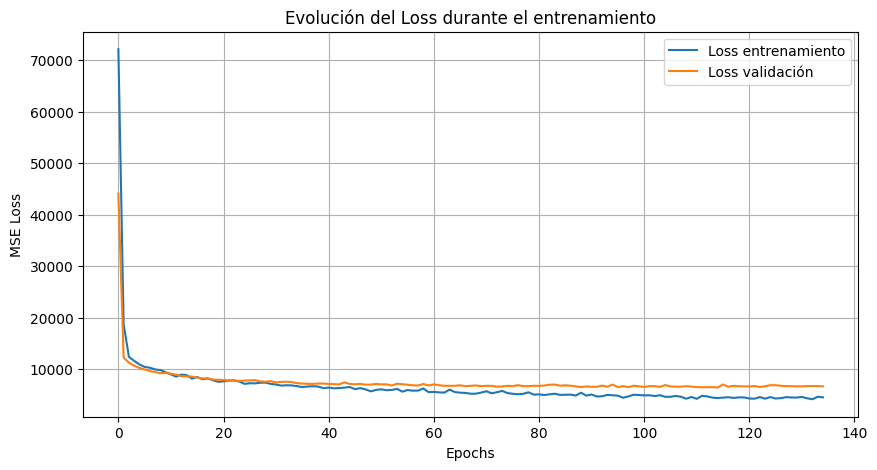

16/16 [==============================] - 0s 960us/step - loss: 6462.1841 - mean_absolute_error: 52.7961

Resultados finales:
MSE: 6462.1841
MAE: 52.7961
RMSE: 80.3877


In [19]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# ============================
# 1. Crear el modelo
# ============================
model = keras.Sequential()

# Capa de entrada
model.add(keras.layers.Input(shape=(X_train.shape[1],)))

# Capas ocultas
for _ in range(3):
    model.add(keras.layers.Dense(
        64,
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.0005)
    ))
    model.add(keras.layers.Dropout(0.2))

# Capa de salida (lineal)
model.add(keras.layers.Dense(1))

# Compilación
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)

# ============================
# 2. Early Stopping
# ============================
early_stop = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)

# ============================
# 3. Entrenamiento del modelo
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)

# ============================
# 4. Graficar Loss vs Epochs
# ============================
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Loss entrenamiento")
plt.plot(history.history["val_loss"], label="Loss validación")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Evolución del Loss durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 5. Evaluación final
# ============================
mse, mae = model.evaluate(X_test, y_test)

print("\nResultados finales:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {mse**0.5:.4f}")
